In [ ]:
!pip install pytorch-lightning pytorch-forecasting --quiet
!pip install optuna --quiet  # For tuning if needed


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Imports
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [ ]:
tickers = [
    'AAPL', 'MSFT', 'NVDA', 'AMZN', 'GOOGL',
    'META', 'TSLA', 'BRK-B', 'JPM', 'V',
    'SAP.DE', 'SIE.DE', 'ALV.DE', 'VOW3.DE', 'LIN.DE',
    'MC.PA', 'OR.PA', 'AIR.PA', 'ASML.AS', 'NESN.SW'
]

start_date = '2010-01-01'
end_date = '2025-03-31'

def download_data(tickers, start, end):
    return yf.download(tickers, start=start, end=end, group_by='ticker', auto_adjust=True, progress=True)

raw_data = download_data(tickers, start_date, end_date)


[*********************100%***********************]  20 of 20 completed


In [ ]:
def preprocess_data(data, tickers, lookback=5):
    processed = {}
    for ticker in tickers:
        if ticker not in data:
            continue

        df = data[ticker].copy()
        if isinstance(df.index, pd.DatetimeIndex):
            df.index = df.index.tz_localize(None)

        df['Return'] = df['Close'].pct_change()
        df['Volatility'] = df['Return'].rolling(21).std()
        df['Dollar_Volume'] = df['Close'] * df['Volume']

        for lag in range(1, lookback + 1):
            df[f'Return_lag_{lag}'] = df['Return'].shift(lag)

        df['Target'] = df['Close'].pct_change(5).shift(-5)
        df = df.dropna()

        if len(df) > 100:
            processed[ticker] = df

    return processed

processed_data = preprocess_data(raw_data, tickers)


In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.model(x.reshape(x.size(0), -1))


In [ ]:
def train_and_evaluate_nbeats(df, feature_cols, target_col='Target', lookback=30, n_splits=3, batch_size=64, epochs=20, lr=1e-3):
    X_all, y_all = [], []

    scaler = RobustScaler()
    scaled = scaler.fit_transform(df[feature_cols])
    target = df[target_col].values

    for i in range(lookback, len(df)):
        X_all.append(scaled[i - lookback:i])
        y_all.append(target[i])

    X_all = np.array(X_all)
    y_all = np.array(y_all)

    tscv = TimeSeriesSplit(n_splits=n_splits)
    fold_scores = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_all)):
        X_train, X_test = X_all[train_idx], X_all[test_idx]
        y_train, y_test = y_all[train_idx], y_all[test_idx]

        train_ds = TimeSeriesDataset(X_train, y_train)
        test_ds = TimeSeriesDataset(X_test, y_test)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

        model = NBeatsBlock(input_size=lookback * len(feature_cols))
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        # Train
        model.train()
        for epoch in range(epochs):
            for X_batch, y_batch in train_loader:
                preds = model(X_batch)
                loss = criterion(preds, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Evaluate
        model.eval()
        preds, actuals = [], []
        with torch.no_grad():
         for X_batch, y_batch in test_loader:
          pred = model(X_batch)

          # Convert to flat lists batch-wise
          preds.extend(pred.view(-1).tolist())
          actuals.extend(y_batch.view(-1).tolist())


        rmse = np.sqrt(mean_squared_error(actuals, preds))
        mae = mean_absolute_error(actuals, preds)
        fold_scores.append({'RMSE': rmse, 'MAE': mae})

    avg_rmse = np.mean([s['RMSE'] for s in fold_scores])
    avg_mae = np.mean([s['MAE'] for s in fold_scores])
    return avg_rmse, avg_mae


In [ ]:
results = []

for ticker, df in processed_data.items():
    print(f"\nTraining N-BEATS for: {ticker}")
    feature_cols = [col for col in df.columns if col.startswith(('Return_lag', 'Volatility', 'Dollar'))]

    try:
        rmse, mae = train_and_evaluate_nbeats(df, feature_cols)
        results.append({'Ticker': ticker, 'RMSE': rmse, 'MAE': mae})
    except Exception as e:
        print(f"Skipped {ticker} due to error: {e}")



Training N-BEATS for: AAPL

Training N-BEATS for: MSFT

Training N-BEATS for: NVDA

Training N-BEATS for: AMZN

Training N-BEATS for: GOOGL

Training N-BEATS for: META

Training N-BEATS for: TSLA

Training N-BEATS for: BRK-B

Training N-BEATS for: JPM

Training N-BEATS for: V

Training N-BEATS for: SAP.DE

Training N-BEATS for: SIE.DE

Training N-BEATS for: ALV.DE

Training N-BEATS for: VOW3.DE

Training N-BEATS for: LIN.DE

Training N-BEATS for: MC.PA

Training N-BEATS for: OR.PA

Training N-BEATS for: AIR.PA

Training N-BEATS for: ASML.AS

Training N-BEATS for: NESN.SW


In [ ]:
metrics_df = pd.DataFrame(results)
avg_row = {
    'Ticker': 'AVG_ALL',
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean()
}
metrics_df = pd.concat([metrics_df, pd.DataFrame([avg_row])], ignore_index=True)
display(metrics_df.sort_values(by='RMSE'))


,Ticker,RMSE,MAE
19,NESN.SW,0.026577,0.020945
7,BRK-B,0.029092,0.022028
16,OR.PA,0.034283,0.026451
14,LIN.DE,0.035346,0.016190
12,ALV.DE,0.036568,0.026439
10,SAP.DE,0.036617,0.027290
1,MSFT,0.038346,0.029020
9,V,0.038438,0.029503
8,JPM,0.041774,0.031348
4,GOOGL,0.042158,0.032360


In [ ]:
# Filter out the AVG_ALL row
metrics_only = metrics_df[metrics_df['Ticker'] != 'AVG_ALL']

# Calculate mean RMSE and MAE
mean_rmse = metrics_only['RMSE'].mean()
mean_mae = metrics_only['MAE'].mean()

print(f"Average RMSE across all tickers: {mean_rmse:.5f}")
print(f"Average MAE across all tickers : {mean_mae:.5f}")


Average RMSE across all tickers: 0.04748
Average MAE across all tickers : 0.03555


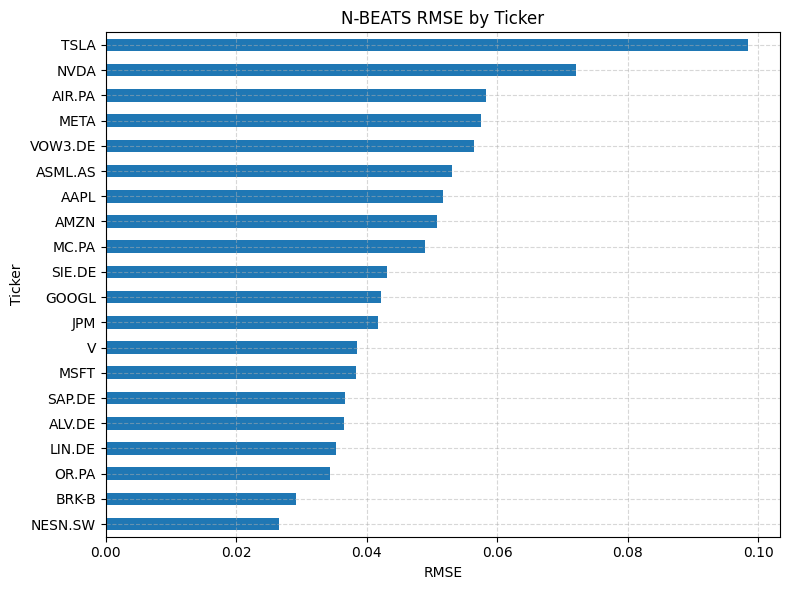

In [ ]:
metrics_only.sort_values(by='RMSE').plot(
    kind='barh', x='Ticker', y='RMSE',
    figsize=(8, 6), title='N-BEATS RMSE by Ticker',
    legend=False
)
plt.xlabel('RMSE')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


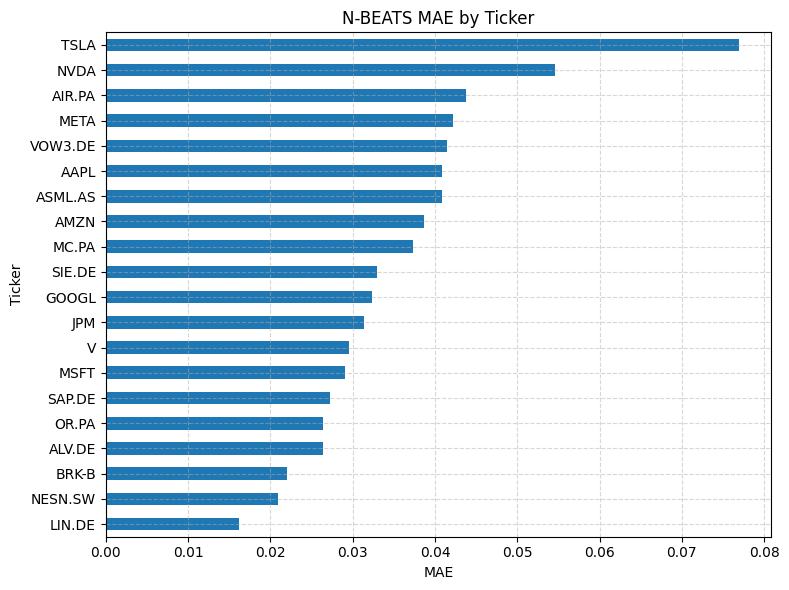

In [ ]:
metrics_only.sort_values(by='MAE').plot(
    kind='barh', x='Ticker', y='MAE',
    figsize=(8, 6), title='N-BEATS MAE by Ticker',
    legend=False
)
plt.xlabel('MAE')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# Prepare AAPL data
ticker = 'AAPL'
df = processed_data[ticker].copy()
feature_cols = [col for col in df.columns if col.startswith(('Return_lag', 'Volatility', 'Dollar'))]

lookback = 30
scaler = RobustScaler()
scaled = scaler.fit_transform(df[feature_cols])

X_all = []
y_all = []

for i in range(lookback, len(df)):
    X_all.append(scaled[i-lookback:i])
    y_all.append(df['Target'].iloc[i])

X_all = np.array(X_all)
y_all = np.array(y_all)

# Train model on full data
dataset = TimeSeriesDataset(X_all, y_all)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

model = NBeatsBlock(input_size=lookback * len(feature_cols))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

model.train()
for epoch in range(20):
    for X_batch, y_batch in loader:
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [ ]:
# Get the most recent lookback window from AAPL
latest_features = df[feature_cols].iloc[-lookback:]
latest_scaled = scaler.transform(latest_features)
latest_input = torch.tensor(latest_scaled, dtype=torch.float32).view(1, lookback, -1)

# Forecast
model.eval()
with torch.no_grad():
    future_pred = model(latest_input).item()


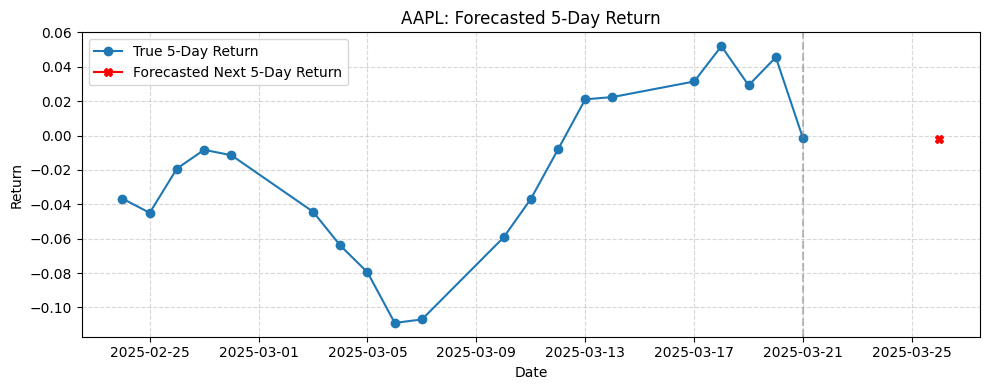

In [ ]:
# For context, show last 20 true returns and the forecast
recent_returns = df['Target'].dropna().iloc[-20:].tolist()
recent_dates = df.index[-20:].tolist()
forecast_date = df.index[-1] + pd.Timedelta(days=5)

plt.figure(figsize=(10, 4))
plt.plot(recent_dates, recent_returns, label='True 5-Day Return', marker='o')
plt.axvline(recent_dates[-1], linestyle='--', color='gray', alpha=0.5)
plt.plot([forecast_date], [future_pred], label='Forecasted Next 5-Day Return', marker='X', color='red')
plt.title('AAPL: Forecasted 5-Day Return')
plt.ylabel('Return')
plt.xlabel('Date')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
